<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Final project - Introduction to DS
</div>

<div style="text-align: center; background-color: #b1d1ff; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Stage 4.0 - Data modelling
</div>

## Problem statement

Sử dụng dữ liệu thu thập được để tạo một hệ thống đề xuất video thông qua một đoạn văn mà người dùng nhập vào công cụ tìm kiếm (giống như chúng ta đang bắt chước hệ thống đề xuất của youtube).

Giải quyết bài toán này sẽ giúp ích cho cả người dùng và nền tảng phát sóng:
- Đôi khi người dùng muốn xem một video nào đó nhưng họ lại không biết nên chọn cái nào trong vô số video hiện có. Khi này, hệ thống đề xuất của chúng ta sẽ gợi ý những video mà người dùng có thể muốn xem nhất thông qua đoạn văn bản mà người dùng nhập vào công cụ tìm kiếm. Khi này, người dùng sẽ có được trải nghiệm sử dụng dịch vụ tốt hơn, đỡ mất nhiều công sức, thời gian để xem thử từng video khác nhau, v.v.
- Với nền tảng phát sóng, việc đề xuất được những video mà người dùng muốn xem sẽ giúp khách hàng sử dụng dịch vụ của họ nhiều hơn. Tất nhiên, có càng nhiều người dùng thì ta sẽ có càng nhiều doanh thu. Ngoài ra, nếu thực sự cần thiết, ta có thể sử dụng số liệu thống kê đó để đi gọi vốn từ các doanh nghiệp lớn, nhằm phát triển các dự án khác trong tương lai.

## Import

In [1]:
import pandas as pd
import numpy as np
import re


# Visualization libraries
import tqdm # Show progress bar
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer

# Sklearn model and util functions
import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans, BisectingKMeans
from sklearn import metrics

# Util libraries
from typing import Dict, List, Any
import itertools
import pickle # Save/Load model parameters

SEED = 2023

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data preparation

Read clean data

In [2]:
clean_df = pd.read_csv('../data/processed/video_data_processed.csv')

In [3]:
# clean_df.sample(5)

## Feature engineering

Clean the video title

In [3]:
clean_df['title'].head(5)

0                          My top 50 scikit-learn tips
1                                21 more pandas tricks
2    Adapt this pattern to solve many Machine Learn...
3    Tune multiple models simultaneously with GridS...
4              Access part of a Pipeline using slicing
Name: title, dtype: object

In [4]:
# Preprocess the data: convert to lowercase, remove special characters, and stopwords
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = [token for token in text.split() if token not in stop_words]
    return ' '.join(tokens)

clean_df['clean_title'] = clean_df['title'].apply(preprocess_text)
# clean_df['clean_title'] = clean_df['clean_title'] + "|" + clean_df['video_id']

In [5]:
clean_df['clean_title'].head(5)

0                                 top scikitlearn tips
1                                        pandas tricks
2    adapt pattern solve many machine learning prob...
3     tune multiple models simultaneously gridsearchcv
4                   access part pipeline using slicing
Name: clean_title, dtype: object

Create a TF-IDF vectorizer

In [6]:
# Create a TF-IDF vectorizer to vectorize the text
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english',
                             min_df=2, # !ADD THIS LINE TO REDUCE THE VOCABULARY SIZE
                             dtype=np.float32)
vectorizer.fit(clean_df['clean_title'])

TfidfVectorizer(dtype=<class 'numpy.float32'>, min_df=2, stop_words='english')

Split data into training, validating and testing set

In [7]:
# Split the data into `train` and `vaild + test` sets
train_data, temp_data = train_test_split(clean_df['clean_title'], 
                                         test_size=0.2, random_state=SEED)
# Further split the temporary set into validation and test sets
valid_data, test_data = train_test_split(temp_data,
                                         test_size=0.5, random_state=SEED)


## Baseline Model Comparison

In [8]:
# Define a dictionary to store clustering models
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster
baseline_parameters = {
    "n_clusters": 5, "init": "k-means++", 
    "n_init": 1, "random_state": SEED,
}
baseline_models = {
    'KMeans': KMeans(**baseline_parameters),
    'BisectingKMeans': BisectingKMeans(**baseline_parameters),
    'MiniBatchKMeans': MiniBatchKMeans(**baseline_parameters),
}

# Define K-Fold cross-validation
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
K_FOLDS = 5
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

# Store the history of cross-validation process
entries = []

# Do k-fold cross validation
for i, (train_ids, valid_ids) in enumerate(kfold.split(train_data), start=1):
    # Check for duplicates index in `train_ids` and `valid_ids`
    assert len(set(train_ids).intersection(set(valid_ids))) == 0

    # Convert text to numerical data using TF-IDF
    data_to_train = vectorizer.transform(train_data.iloc[train_ids])
    data_to_valid = vectorizer.transform(train_data.iloc[valid_ids])

    print(f"\n------------------ Fold {i} ------------------")
    for model_name, model in baseline_models.items():
        print(f"{model_name.rjust(15)}: Fitting... ", end="")
        
        # Fit the model to the training data
        model.fit(data_to_train)

        # Evaluate the model on the validation data
        # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score
        print(f"-> Evaluating...")
        labels_pred = model.predict(data_to_valid)
        silhouette_score \
            = metrics.silhouette_score(data_to_valid, 
                                       labels_pred, metric='euclidean')

        # Add new record to the history
        entries.append([model_name, i, silhouette_score])

# Create a dataframe to store the results
cross_validation_df = pd.DataFrame(
    data=entries,
    columns=["model_name", "fold_id", "silhouette_score"]
)
# ~ 3min


------------------ Fold 1 ------------------
         KMeans: Fitting... -> Evaluating...
BisectingKMeans: Fitting... -> Evaluating...
MiniBatchKMeans: Fitting... -> Evaluating...

------------------ Fold 2 ------------------
         KMeans: Fitting... -> Evaluating...
BisectingKMeans: Fitting... -> Evaluating...
MiniBatchKMeans: Fitting... -> Evaluating...

------------------ Fold 3 ------------------
         KMeans: Fitting... -> Evaluating...
BisectingKMeans: Fitting... -> Evaluating...
MiniBatchKMeans: Fitting... -> Evaluating...

------------------ Fold 4 ------------------
         KMeans: Fitting... -> Evaluating...
BisectingKMeans: Fitting... -> Evaluating...
MiniBatchKMeans: Fitting... -> Evaluating...

------------------ Fold 5 ------------------
         KMeans: Fitting... -> Evaluating...
BisectingKMeans: Fitting... -> Evaluating...
MiniBatchKMeans: Fitting... -> Evaluating...


Visualize the results

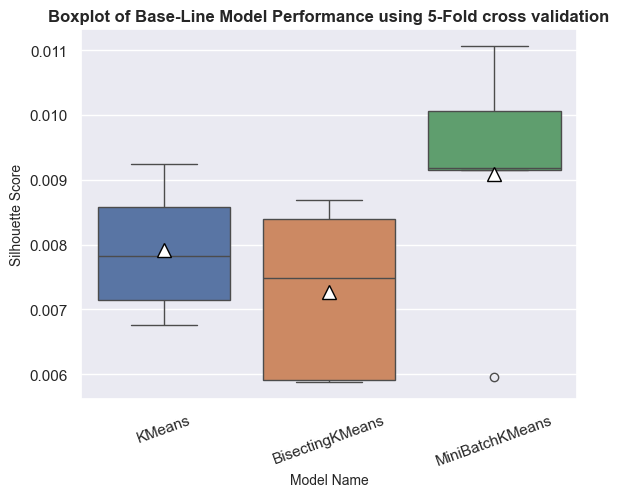

In [20]:
# Plot the results
sns.boxplot(x='model_name', y='silhouette_score', hue='model_name',
            data=cross_validation_df, showmeans=True,
            palette=sns.color_palette()[:baseline_models.__len__()],
            # Reference: https://matplotlib.org/stable/api/markers_api.html
            meanprops={"marker":"^","markerfacecolor":"white", 
                       "markeredgecolor":"black", "markersize":"10"}
            )
plt.title(f"Boxplot of Base-Line Model Performance using {K_FOLDS}-Fold cross validation",
          fontsize=12, fontweight="bold")
plt.xlabel("Model Name", fontsize=10)
plt.ylabel("Silhouette Score", fontsize=10)
plt.xticks(rotation=20)
plt.show();

Summarize the results

In [21]:
# Summarize the results
baseline_results = \
    cross_validation_df.groupby('model_name')["silhouette_score"]\
        .agg(['mean', 'std']).sort_values(by='mean', ascending=False)

# Add metric names
baseline_results.columns.name = "silhouette_score"

baseline_results

silhouette_score,mean,std
model_name,,
MiniBatchKMeans,0.009081,0.001912
KMeans,0.007909,0.001020
BisectingKMeans,0.007269,0.001330


> Nhận xét: `MiniBatchKMeans` là "baseline model" chạy tốt nhất trên tập dữ liệu `train_data`. Ở bước tiếp theo, ta cần thực hiện "Hyper-parameter Tuning" để giúp các model tạo ra kết quả tốt hơn nữa.

## Hyper-parameter Tuning

### Getting the optimal number of clusters

In [40]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# wcss - within cluster sum of squared distances
wcss_df = pd.DataFrame(columns=['n_clusters', 'model_name', 'wcss'])
models = {
    'KMeans': KMeans,
    'BisectingKMeans': BisectingKMeans,
    'MiniBatchKMeans': MiniBatchKMeans,
}

data = vectorizer.transform(train_data)
K = list(range(3, 21, 1))
K = list(range(3, 21, 1))

with tqdm.tqdm(total=len(K)) as pbar:
    pbar.set_description("Elbow Method progress")
    for n_clusters in K:
        for model_name, model_prototype in models.items():
            model = model_prototype(n_clusters=n_clusters, random_state=SEED,
                                    init='k-means++', n_init=1)
            model.fit(data)
            wcss_df.loc[len(wcss_df)] = [n_clusters, model_name, model.inertia_]
        
        pbar.update(1)

# ~ 4min

Elbow Method progress: 100%|██████████| 18/18 [01:26<00:00,  4.82s/it]


Visualize the results

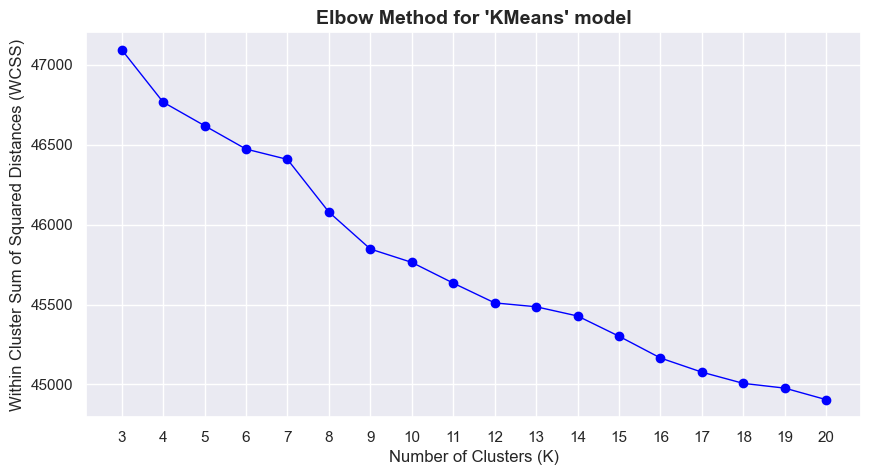

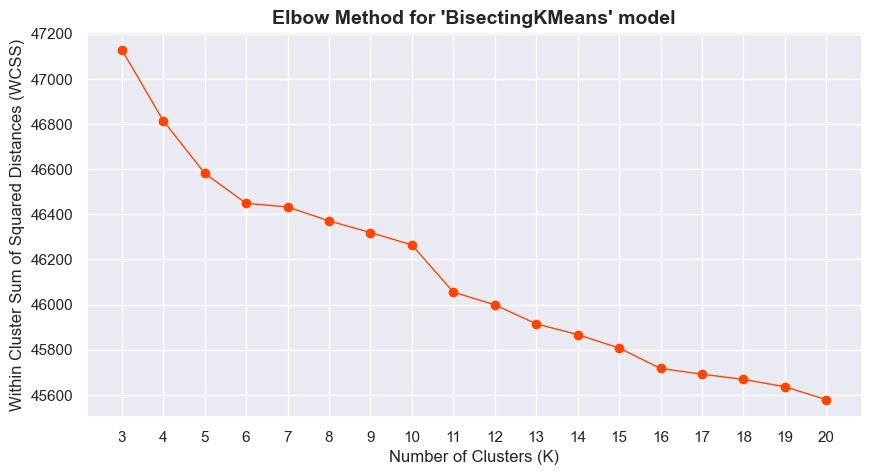

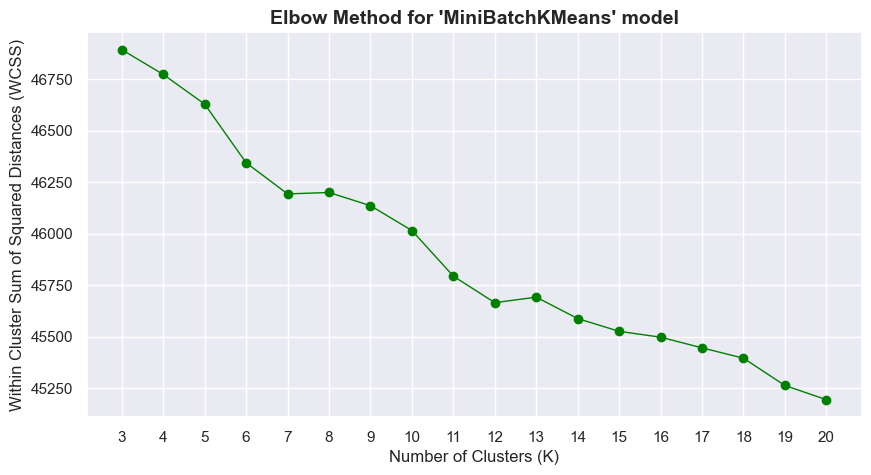

In [41]:
colors = ['blue', 'orangered', 'green']
for i, model_name in enumerate(models.keys()):
    ax = wcss_df.query(f"model_name == '{model_name}'").plot.line(
        x='n_clusters', y='wcss', figsize=(10, 5),
        marker='o', color=colors[i], linewidth=1,
        legend=False,
    )
    ax.set_xticks(K)
    ax.set_title(f"Elbow Method for \'{model_name}\' model",
                 fontdict={'fontsize': 14, 'fontweight': 'bold'})
    ax.set_xlabel("Number of Clusters (K)")
    ax.set_ylabel("Within Cluster Sum of Squared Distances (WCSS)")
    

> <u>**Nhận xét**</u>: Quan sát các biểu đồ trên, ta thấy rằng các tham số `n_clusters` nên được sử dụng để tinh chỉnh mô hình là: `[6, 7, 11, 12, 16]`.

Biểu đồ của mô hình `MiniBatchKMeans` có vẻ khó quan sát nên ta sẽ đồng ý với việc sử dụng giá trị tốt nhất của hai mô hình còn lại (`KMeans` và `BisectingKMeans`) là `K = 15`

### For the other hyper-parameters

In [80]:
def _hyperParameters_tuning(model: sklearn.cluster, 
                            hyperParams_grid: Dict[str, List]) -> Dict[str, Any]:
    best_score: float = 0.0
    best_hyperParams: Dict[str, Any] = None

    # Get all combinations
    all_combinations = list(itertools.product(*hyperParams_grid.values()))

    # Create a list of dictionaries for each combination
    hyperParams_combinations = [dict(zip(hyperParams_grid.keys(), combination)) 
                                for combination in all_combinations]

    # Convert text to numerical data using TF-IDF
    _data_to_train = vectorizer.transform(train_data)
    _data_to_valid = vectorizer.transform(valid_data)

    print(f"========== Fine-tuning '{model.__class__.__name__}' on total {len(hyperParams_combinations)} hyper-parameter combinations ==========")
    for i, hyperParams in enumerate(hyperParams_combinations,start=1):
        # Set hyperparameters
        model.set_params(**hyperParams)
        
        # Fit the model to the training data
        print(f"Fitting on combination {str(i).rjust(2)}...", end="")
        model.fit(_data_to_train)
        
        # Evaluate the model on the validation data
        print(f" -> Evaluating...", end="")
        pred = model.predict(_data_to_valid)
        score = metrics.silhouette_score(_data_to_valid, pred, metric='euclidean')

        if score > best_score:
            print(f" -> Get new best-score: {score:.6f}, updating best-hyper-parameters...")
            best_score = score
            best_hyperParams = hyperParams
        else:
            print(f" -> Best-score remains: {best_score:.6f}")
            
    return best_hyperParams


#### KMeans

In [ ]:
kmeans_best_hyperParams = _hyperParameters_tuning(KMeans(), {
    'verbose': [0],
    'random_state': [SEED],
    'max_iter': [300],
    'n_init': [1],
    'tol': [1e-6],
    
    'init': ['k-means++', 'random'],
    'algorithm': ['lloyd', 'elkan'],
    'n_clusters': [6, 7, 11, 12, 16],
}) # ~ 2min
kmeans_best_hyperParams

#### BisectingKMeans

In [ ]:
bisecting_kmeans_best_hyperParams = \
    _hyperParameters_tuning(BisectingKMeans(), {
        'verbose': [0],
        'random_state': [SEED],
        'max_iter': [300],
        'n_init': [1],
        'tol': [1e-6],
        
        'init': ['k-means++', 'random'],
        'algorithm': ['lloyd', 'elkan'],
        'bisecting_strategy': ['biggest_inertia', 'largest_cluster'],
        'n_clusters': [6, 7, 11, 12, 16],
    }) # ~ 6min
bisecting_kmeans_best_hyperParams

#### MiniBatchKMeans

In [ ]:
minibatch_kmeans_best_hyperParams = \
    _hyperParameters_tuning(MiniBatchKMeans(), {
        'verbose': [0],
        'random_state': [SEED],
        'max_iter': [300],
        'n_init': [10],
        'tol': [1e-6],
        'init_size': [None],
        'batch_size': [1024],
        
        'init': ['k-means++', 'random'],
        'n_clusters': [6, 7, 11, 12, 16],
        'max_no_improvement': [10, 20],
        'reassignment_ratio': [0.01, 0.001, 0.0001]
    }) # ~ 2min
minibatch_kmeans_best_hyperParams

## Training models and evaluation

Create models with the best hyper-parameters and save them for future use

In [71]:
# Get the best model
best_kmeans_model = KMeans(**kmeans_best_hyperParams)
best_bisecting_kmeans_model = BisectingKMeans(**bisecting_kmeans_best_hyperParams)
best_minibatch_kmeans_model = MiniBatchKMeans(**minibatch_kmeans_best_hyperParams)

best_models = {
    'best_kmeans_model': best_kmeans_model,
    'best_bisecting_kmeans_model': best_bisecting_kmeans_model,
    'best_minibatch_kmeans_model': best_minibatch_kmeans_model,
}

# Save the best model for later use
# Reference: https://stackoverflow.com/questions/54879434/how-to-use-pickle-to-save-sklearn-model
for model_name, model in best_models.items():
    with open(f"../data/models/{model_name}.pkl", "wb") as f:
        pickle.dump(model, f)

Load models if needed

In [9]:
best_models_lst = ['best_kmeans_model', 'best_bisecting_kmeans_model', 'best_minibatch_kmeans_model']
best_models = {}
# Load model if needed
for model_name in best_models_lst:
    with open(f"../data/models/{model_name}.pkl", "rb") as f:
        best_models[model_name] = pickle.load(f)
        print(f"[LOG] Loaded model '{model_name}'")

print(f">> Total number of models: {best_models.__len__()}")

[LOG] Loaded model 'best_kmeans_model'
[LOG] Loaded model 'best_bisecting_kmeans_model'
[LOG] Loaded model 'best_minibatch_kmeans_model'
>> Total number of models: 3


(Re-)Train models on (`training + validating` set) and evaluate them on `testing` set

In [ ]:
# Store the result to dateframe
# history_df = pd.DataFrame(columns=["model_name", "n_init", "score"])
history_df = pd.DataFrame(columns=["model_name", "max_iter", "score"])

# Combine train and validation data
final_train_data = pd.concat([train_data, valid_data], axis=0)

# Convert text to numerical data using TF-IDF
data_to_train = vectorizer.transform(final_train_data)
data_to_test = vectorizer.transform(test_data)

MAX_ITERS = range(1,11,2)
for max_iter in MAX_ITERS:
    # for n_init in range(1, 6):
    for model_name, model in best_models.items():
        # Update parameters of model
        model.random_state = SEED
        # model.n_init = n_init
        model.max_iter = max_iter
    
        # Fit each model on `data_to_train`
        model.fit(data_to_train)
        # Evalute model on `data_to_test`
        pred = model.predict(data_to_test)
        score = metrics.silhouette_score(data_to_test, pred)
        print(f"{model_name.rjust(15)} - {max_iter}: {score}")
    
        # Update history
        history_df.loc[len(history_df)] = [model_name, max_iter, score]
        

## Results analysis

Visualize the results

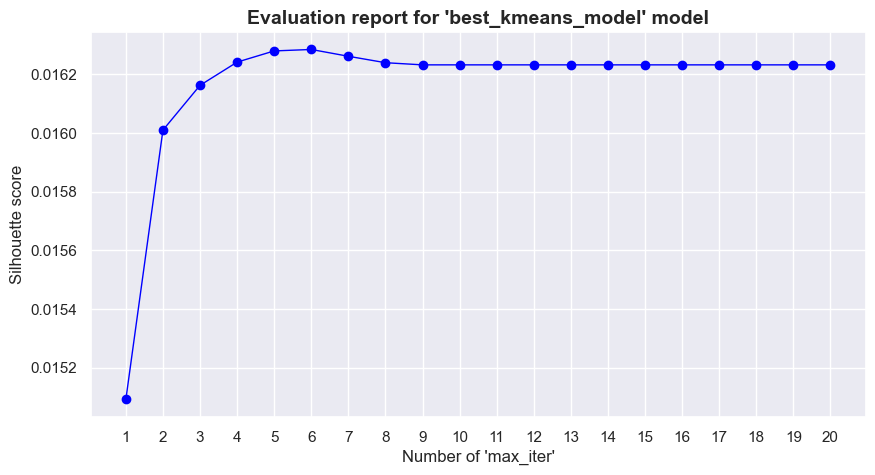

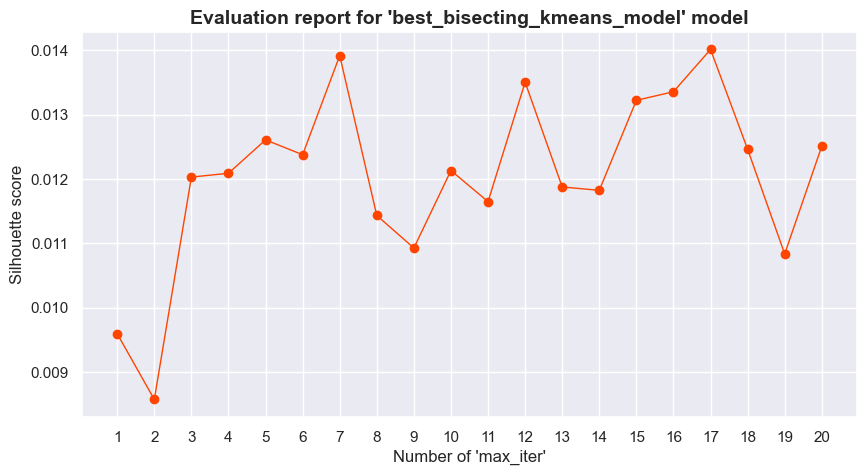

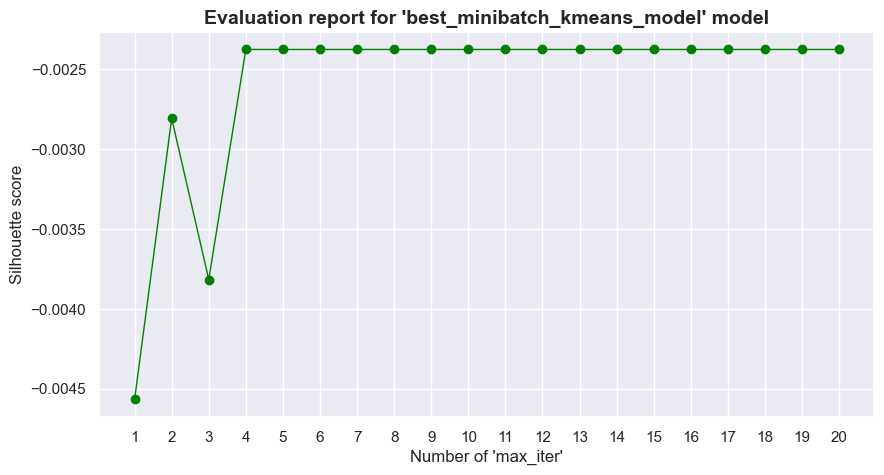

In [20]:
# Visualize the results
colors = ['blue', 'orangered', 'green']
for i, model_name in enumerate(best_models.keys()):
    ax = history_df.query(f"model_name == '{model_name}'").plot.line(
        x='max_iter', y='score', figsize=(10, 5),
        marker='o', color=colors[i], linewidth=1,
        legend=False,
    )
    ax.set_xticks(MAX_ITERS)
    ax.set_title(f"Evaluation report for \'{model_name}\' model",
                 fontdict={'fontsize': 14, 'fontweight': 'bold'})
    ax.set_xlabel("Number of \'max_iter\'")
    ax.set_ylabel("Silhouette score")
    

Summarize the results

In [19]:
# Summarize the results
eval_results = \
    history_df.groupby('model_name')["score"]\
        .agg(['mean', 'std']).sort_values(by='mean', ascending=False)

# Add metric names
eval_results.columns.name = "silhouette_score"

eval_results

silhouette_score,mean,std
model_name,,
best_kmeans_model,0.016168,0.000260
best_bisecting_kmeans_model,0.012045,0.001354
best_minibatch_kmeans_model,-0.002579,0.000573


## Conclusion

Như vậy, `best_kmeans_model` là mô hình hoạt động tốt nhất trên tập dữ liệu của chúng ta. Do đó, ta sẽ tận dụng mô hình này để giải quyết bài toán đã đề ra ban đầu.

## Clustering all video titles

Define `my_best_model` and optimize it

In [8]:
# Define the best model
best_model_name = 'best_kmeans_model'
my_best_model = None
with open(f"../data/models/{best_model_name}.pkl", "rb") as f:
    my_best_model = pickle.load(f)
    # print(f"[LOG] Loaded model '{best_model_name}'")

# Display the best model
my_best_model

KMeans(algorithm='elkan', n_clusters=16, n_init=1, random_state=2023, tol=1e-06)

In [9]:
# Optimize the model
my_best_model.n_init = 10

In [10]:
# TEST
my_best_model.get_params()

{'algorithm': 'elkan',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 16,
 'n_init': 10,
 'random_state': 2023,
 'tol': 1e-06,
 'verbose': 0}

Train `my_best_model` on all video data in dataset

In [11]:
# Combine train, validation and test data
all_video_data = pd.concat((train_data, valid_data, test_data), axis=0)

# Convert text to numerical data using TF-IDF
data = vectorizer.transform(all_video_data)

# Train the model on all data
my_best_model.fit(data)

# Get the labels (cluster_id) of all data
labels = my_best_model.predict(data)
# ~ 4min

Use prediction result to assign `cluster_id` to each video in dataset

In [14]:
video_cluster_df = pd.DataFrame({
    'index': all_video_data.index,
    'cluster_id': labels
})

In [15]:
merged_df = pd.merge(left=video_cluster_df, right=clean_df, 
                     how='inner', left_on='index', right_index=True)

Drop unnecessary columns

In [16]:
# Drop unnecessary columns
unnecessary_cols = ['index', 'clean_title', 'publishedAt.hour', 'publishedAt.day', 
                    'publishedAt.year', 'publishedAt.month']
merged_df.drop(columns=unnecessary_cols, inplace=True)

In [17]:
# TEST
merged_df.sample(3)

,cluster_id,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,publishedAt.dayOfWeek,publishedAt.weekOfYear
50877,2,Gh9HkS_-WRg,Satyajit Pattnaik,Data Visualization | 10 Useful Ways to Visuali...,Data Visualization | 10 Useful Ways to Visuali...,satyajit pattnaik|data science|data analytics|...,2021-12-10 13:30:03+00:00,395,22,7,1183,hd,False,4,49
21746,0,im6qomYIdms,Siddhardhan,ChatGPT - Hyperparameter Tuning of Support Vec...,Code file: https://drive.google.com/file/d/1FR...,machine Learning|ChatGPT|data science,2023-01-07 11:39:02+00:00,4160,175,2,58,hd,False,5,1
5597,11,CWgcH7wXdjw,The Data Incubator,Data Science Ethics: What it Means and Why it ...,Watch this insightful webinar on data science ...,(notag),2022-12-07 18:10:11+00:00,231,1,0,3559,hd,False,2,49


In [18]:
# Save final data for later use
merged_df.to_csv('../data/processed/video_data_clustered.csv', index=False)

# Save the model for later use
with open("../data/models/my_best_model.pkl", "wb") as f:
    pickle.dump(my_best_model, f)

## Prediction

Return top `n` video titles in the same cluster

In [19]:
# Return top `n` video titles in the same cluster
def _recommend_top_n_videos(cluster_id, top_n: int = 10) -> List[str]:
    # Define a dataframe to store the recommended videos
    recommended_videos = pd.DataFrame(columns=['channelTitle', 'title'])
    # !USING THE BELOW CODE FOR TESTING
    # recommended_videos = pd.DataFrame(columns=['channelTitle', 'title', 'viewCount'])
    
    # Define a set to store the channels that have been recommended
    set_of_channels = set()
    
    # Get all videos in the same cluster
    #   Then sort them by their views
    video_in_cluster = merged_df.query(f"cluster_id == {cluster_id}")\
                            .sort_values(by='viewCount', ascending=False)
    
    # Iterate through each video in the cluster
    for i, video in video_in_cluster.iterrows():
        channelTitle = video['channelTitle']
        videoTitle = video['title']
        
        # If the channel has already been recommended, skip it
        if channelTitle in set_of_channels:
            continue
        
        # Otherwise, add it to the list of recommended channels
        if len(recommended_videos.columns) == 2:
            recommended_videos.loc[len(recommended_videos)] = [channelTitle, videoTitle]
        else: # !USING THE BELOW CODE FOR TESTING
            recommended_videos.loc[len(recommended_videos)] = [channelTitle, videoTitle, video['viewCount']]
        
        # Add the channel to the set
        set_of_channels.add(channelTitle)
        
        # If we have enough channels, stop
        if len(recommended_videos) >= top_n:
            break        
    
    return recommended_videos

Assign `cluster_id` for new text data

In [20]:
# Assuming 'new_data' is a list of new video titles
new_data = ["Tech news and updates",
            "How to learn programming in 2023",
            "Top 10 Python tips and tricks",
            "Machine learning explained in 5 minutes",
            "How to become a Data Analyst",
            ]

new_data = pd.Series(new_data)
text_values = new_data.apply(preprocess_text)

# Transform the preprocessed new data into TF-IDF features using the same vectorizer
new_tfidf_matrix = vectorizer.transform(text_values)

# Use the trained k-means model to predict cluster labels for the new data
pred_labels = my_best_model.predict(new_tfidf_matrix)

Show some results

In [21]:
# Display the results
for i, title in enumerate(new_data):
    recommended_videos = _recommend_top_n_videos(pred_labels[i], top_n=5)
    print(f"Recommended videos for '{title}':")
    print(recommended_videos)
    print("--------------------------------------\n")

Recommended videos for 'Tech news and updates':
        channelTitle                                              title
0    Google DeepMind  AlphaGo - The Movie | Full award-winning docum...
1          Joma Tech  a day in the life of an engineer working from ...
2        3Blue1Brown  But what is a Fourier series?  From heat flow ...
3        Lex Fridman  Jordan Peterson: Life, Death, Power, Fame, and...
4  Two Minute Papers  OpenAI Plays Hide and Seek…and Breaks The Game! 🤖
--------------------------------------

Recommended videos for 'How to learn programming in 2023':
        channelTitle                                              title
0         Tina Huang  How I would learn to code (if I could start over)
1            CS Dojo  Top 5 Programming Languages to Learn to Get a ...
2           DataCamp                                Better Way to Learn
3  Two Minute Papers        How Well Can DeepMind's AI Learn Physics? ⚛
4         Krish Naik                 How To Learn Data Scienc

# ----- break -----

In [ ]:
def my_clustering(s, n_clusters, print_clusters=False): 
    text_values = s

    # Convert text to numerical data using TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(text_values)

    # Choose the number of clusters (you may need to adjust this based on your data)
    num_clusters = n_clusters

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X)

    # Print the clusters
    if print_clusters:
        # Get cluster labels
        cluster_labels = kmeans.labels_
        for i in range(num_clusters):
            print(f"Cluster {i + 1}:")
            cluster_texts = np.array(text_values)[cluster_labels == i]
            for text in cluster_texts:
                print(f"  - {text}")
            print("\n")
    
    return kmeans, vectorizer

## Clustering tags

# -------------------- BREAK --------------------

## Feature engineering

In [ ]:
target = "viewCount"
X = clean_df.copy()
X.drop(target, axis=1, inplace=True)
y = clean_df[target].copy()

cat_cols = [col for col in X.columns if X[col].dtype == "object"]
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    # X_val[col] = le.transform(X_val[col])
    # X_test[col] = le.transform(X_test[col])

In [ ]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [ ]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

## Training model and evaluation

In [ ]:
# YOUR CODE HERE (OPTION) 

## Evaluation

In [ ]:
# YOUR CODE HERE (OPTION) 

## Prediction

In [ ]:
# YOUR CODE HERE (OPTION) 

## Results analysis

In [ ]:
# YOUR CODE HERE (OPTION) 

## Conclusion

**Your conclusion**